This will serve as the notebook for testing my topic modeling portion of this project.

After verifying that everything is working, it will be changed to a .py file to be runnable on new incoming data

In [40]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import glob
import warnings
from collections import defaultdict
import re
import pprint

import gensim
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

import spacy
from nltk.corpus import stopwords
# nltk.download('stopwords')
# import en_core_web_sm

#vis
import pyLDAvis
import pyLDAvis.gensim

warnings.filterwarnings("ignore", category=DeprecationWarning)  # Lots of depreciation warnings with spacy/gensim. ignore

In [2]:
df = pd.read_csv(r"data/2014_funny_comments.csv")

In [3]:
df = df[~df.body.isnull()]  # Remove the missed null values

conditions = [ (df['score'] < 1), (df['score'] >= 1) & (df['score'] <= 13), (df['score'] > 13) ] 
values = ['bad', 'okay', 'good']
df['flag'] = np.select(conditions, values)  # Bin our scores into categories under the column name 'flag'
df.drop(columns=['HOUR_int', 'DAY_int', 'MONTH_int'], inplace=True)  # Won't use time info here

df.head()

,score,body,flag
0,1,Ain't no half steppin,okay
1,7,Inside the gas tank cover or on top of a tire,okay
2,12,Brought to you by /r/SummerReddit,okay
3,1,This makes me want to murder.,okay
4,3,I know someone who got a DUI sleeping it off i...,okay


In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['re'])
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])  # Won't be using NER nor the parser
def text_preproc(row):
    """

    Args:
        row (str): str representing a comment in a row of a dataframe
    """
    text = str(row['body']) 
    text = text.encode('ascii', errors = 'ignore').decode()  # Remove non-ascii characters
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.lower()  # Set to lowercase
    text = text.strip()  # Remove whitespace
    text = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)  # Remove URLs
    text = re.sub(r'[:"#$%&\*+,-/:;<=>@\\^_`{|}~.\'!?]+','',text)  # Remove punctuation
    text = re.sub(r'[()]', '', text)  # Remove parens specifically
    text = re.sub(r'[\[\]]', '', text)  # Remove brackets specifically
    text = " ".join([word for word in text.split() if (word not in stop_words) and len(word) > 1])  # Make the sentence into a list of words if it's not a stopword and longer than 1 character
    
    return text

In [ ]:
# # Smaller df to test on
# dfcopy = df.copy()
# smdf = dfcopy.iloc[:100000]
# smdf['cComment'] = smdf.apply(text_preproc, axis=1)
# smdf = smdf[~smdf.cComment.apply(lambda x: len(x.split()) == 0)]  # Remove the now empty strings after cleaning
# smdf.reset_index(inplace=True)  # Reset index after removal of rows
# smdf

In [ ]:
# smsents = smdf.cComment.values.tolist()  # small batch of cleaned sentences to test with

In [5]:
def comment_to_words(comments):
    """
    Takes in the comments as a list and returns a list of tokens via gensim.  
    This lowercases, tokenizes, and de-accents the comments as well
    
    Args:
        comments (list): list of (cleaned) comments to preprocess with gensim
    """
    for comment in comments:
        yield(gensim.utils.simple_preprocess(str(comment), deacc=True))  # Text may contain accent marks as it's comment data, may not be english

In [6]:
dfcopy = df.copy()
goodComments = dfcopy[dfcopy.flag=='good']
goodComments['cComment'] = goodComments.apply(text_preproc, axis=1)
goodComments = goodComments[~goodComments.cComment.apply(lambda x: len(x.split()) < 2)]  # Remove any words with fewer than three characters
goodComments.reset_index(inplace=True)
goodsents = goodComments.cComment.values.tolist()
data_words = list(comment_to_words(goodsents))

C:\Users\Zade\AppData\Local\Temp\ipykernel_9940\3379192874.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  goodComments['cComment'] = goodComments.apply(text_preproc, axis=1)


In [ ]:
# data_words = list(comment_to_words(smsents))
# data_words[:4]

In [8]:
bigrams = gensim.models.Phrases(data_words, min_count=5000)   # Large min_count  as we'll have huge amount of data
# trigrams = gensim.models.Phrases(bigrams[data_words], threshold=1000)  # Don't look at trigrams for 1st pass

bigram_mod = gensim.models.phrases.Phraser(bigrams)
# trigram_mod = gensim.models.phrases.Phraser(trigrams)

In [7]:
def lemmatizePOS(comments, allowed_pos=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in comments:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_pos])
    return texts_out

def make_bigrams(comments):
    return [bigram_mod[doc] for doc in comments]

def make_trigrams(comments):
    return [trigram_mod[bigram_mod[doc]] for doc in comments]

In [9]:
data_bigrams = make_bigrams(data_words)
data_lemmatized = lemmatizePOS(data_bigrams)

In [12]:
# Remove words if they are just 1 or 2 characters long
frequency = defaultdict(int)

for text in data_lemmatized:
    for token in text:
        frequency[token] += 1
        
texts = [
    [token for token in text if len(token) > 2]
    for text in data_lemmatized
]

In [20]:
# TF-IDF Removal testing
id2word = corpora.Dictionary(texts)  
id2word.filter_extremes(no_below=20, no_above=0.5)  # Filter words that occur in less than 20 documents or more than 50% of documents
corpus = [id2word.doc2bow(comment) for comment in texts]  # Make our bag of words
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.05
for i in range(0, len(corpus)):
    bow = corpus[i]
    low_value_words = [] 
    tfidf_ids = [id for id, value in tfidf[bow]]
    bow_ids = [id for id, value in bow]
    low_value_words = [id for id, value in tfidf[bow] if value < low_value]
    words_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids] # The words with tf-idf socre 0 will be missing

    new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]  

#reassign        
corpus[i] = new_bow

In [51]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5,
                                           random_state=543,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha="auto",
                                           eta="auto"
                                           )

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [23]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=1, limit=32, step=5)

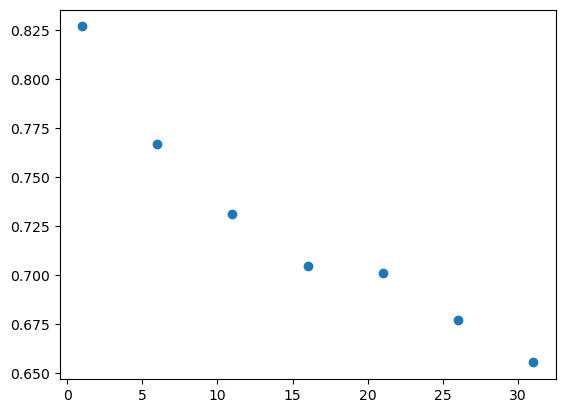

In [24]:
x = range(1, 32, 5)
plt.scatter(x, coherence_values)

In [26]:
for m, cv in zip(x, coherence_values):
    print(f"Num Topics: {m}, CV: {cv}")

Num Topics: 1, CV: 0.8268960493026734
Num Topics: 6, CV: 0.7668491148514757
Num Topics: 11, CV: 0.7309916053363126
Num Topics: 16, CV: 0.7048314704831966
Num Topics: 21, CV: 0.7007879027307349
Num Topics: 26, CV: 0.67708537329947
Num Topics: 31, CV: 0.6553543193156981


In [32]:
res[-1][0]

In [34]:
res = sorted(zip(model_list, coherence_values), key = lambda x: x[1])  # Sort the models by cv in ascending order
best_model = res[-1][0]  # Select the best model by cv

In [54]:
pyLDAvis.enable_notebook()
warnings.filterwarnings("ignore", category=FutureWarning)
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)  #### Issue with plotting best_model
warnings.filterwarnings("default", category=FutureWarning)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.431296 -0.022654       1        1  36.242562
4      0.137523 -0.395832       2        1  19.818301
1      0.119876  0.240972       3        1  18.001429
0      0.094550  0.111378       4        1  13.398991
3      0.079347  0.066136       5        1  12.538717, topic_info=        Term           Freq          Total Category  logprob  loglift
193     know   58717.000000   58717.000000  Default  30.0000  30.0000
16       get  117559.000000  117559.000000  Default  29.0000  29.0000
12       see   58463.000000   58463.000000  Default  28.0000  28.0000
236      say   57915.000000   57915.000000  Default  27.0000  27.0000
67      time   51558.000000   51558.000000  Default  26.0000  26.0000
...      ...            ...            ...      ...      ...      ...
140     dead    5193.499298    5194.341742   Topic5  -5.2126   2.0762
1468     add    5119.855348    5120.698317   Topic5  -5.2269   2.0762
1006  season    5059.820311    5060.662368   Topic5  -5.2387   2.0762
771     poor    5045.946367    5046.790634   Topic5  -5.2414   2.0762
1079   shoot    4901.295458    4902.140260   Topic5  -5.2705   2.0762

[180 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
37        1  0.999968  actually
1468      5  0.999864       add
812       4  0.999902    almost
262       1  0.999974      also
536       1  0.999977    always
...     ...       ...       ...
569       4  0.999910      word
54        1  0.999977      work
363       3  0.999903     world
315       2  0.999893     wrong
61        1  0.999961      year

[150 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 1, 4])

In [38]:
model_topics = best_model.show_topics(formatted=False)

In [50]:
best_model

In [52]:
lda_model

In [49]:
best_model.show_topics(-1)

[(0,
  '0.015*"get" + 0.009*"make" + 0.009*"people" + 0.009*"think" + 0.008*"say" + 0.008*"know" + 0.007*"see" + 0.007*"time" + 0.005*"good" + 0.005*"thing"')]

In [ ]:
# Save model
# lda_model.save(r"data/models/LDAmodel.model")
# Load model
# new_model = gensim.models.ldamodel.LdaModel.load(r"data/models/LDAmodel.model")